# Inputs

In [1]:
splitPartCount = 5
splitSeed = 27
hoursPerWindow = 1

# Preproccess

## read data

In [2]:
from utils.class_patient import Patients


patients = Patients.loadPatients()
len(patients)

1213

## remove missing

In [3]:
# fill measures whose null represent false value

from constants import NULLABLE_MEASURES


nullableMeasures = NULLABLE_MEASURES

for measureName in nullableMeasures:
    patients.fillMissingMeasureValue(measureName, 0)

In [4]:
# remove measures with less than 80% of data

measures = patients.getMeasures()

for measure, count in measures.items():
    if count < len(patients) * 80 / 100:
        patients.removeMeasures([measure])
        print(measure, count)

pco2 917
ph 954
po2 917
albumin 406
hba1c 326
lymphocyte 446
height 415
urine-ketone 294
crp 19


In [5]:
# remove patients with less than 80% of data

patients.removePatientByMissingFeatures()
len(patients)

1206

In [6]:
# # remove patients with positive tag in first 12 hours

from pandas import Timedelta


patients.removePatientAkiEarly(Timedelta(hours=12))

82

In [7]:
print("Total ", len(patients))
print("AKI ", sum([1 for p in patients if p.akdPositive]))
print("Ratio ", sum([1 for p in patients if p.akdPositive]) / len(patients))

Total  1124
AKI  392
Ratio  0.3487544483985765


## split patients

In [8]:
splitedPatients = patients.split(splitPartCount, splitSeed)

len(splitedPatients[0])

225

In [9]:
splitedPatients = patients.split(splitPartCount, splitSeed)


def trainTest():
    for i in range(splitedPatients.__len__()):
        testPatients = splitedPatients[i]

        trainPatientsList = splitedPatients[:i] + splitedPatients[i + 1 :]
        trainPatients = Patients(patients=[])
        for trainPatientsElem in trainPatientsList:
            trainPatients += trainPatientsElem

        yield trainPatients, testPatients


def trainValTest():
    for i in range(splitedPatients.__len__()):
        testPatients = splitedPatients[i]

        trainPatientsList = splitedPatients[:i] + splitedPatients[i + 1 :]
        trainPatients = Patients(patients=[])
        for trainPatientsElem in trainPatientsList:
            trainPatients += trainPatientsElem

        *trainPatients, valPatients = trainPatients.split(5, 27)
        tmpPatients = Patients(patients=[])
        for trainPatientsElem in trainPatients:
            tmpPatients += trainPatientsElem
        trainPatients = tmpPatients

        yield trainPatients, valPatients, testPatients

In [10]:
for trainPatients, testPatients in trainTest():
    print(len(trainPatients.patientList), len(testPatients.patientList))

899 225
899 225
899 225
899 225
900 224


# LSTM

### Seperate static and dynamic

In [11]:
from keras.models import Sequential, Model
from keras.layers import (
    LSTM,
    Dense,
    Dropout,
    Input,
    Concatenate,
    Masking,
    Conv1D,
    MaxPooling1D,
    BatchNormalization,
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import tensorflow as tf


def createModel2(timeSteps, timeFeatures, staticFeatures):
    # time series layers
    timeInputLayer = Input(shape=(timeSteps, timeFeatures))
    # maskingLayer = Masking(mask_value=0.0)(timeInputLayer)
    # cnnLayer = Conv1D(64, 3, activation="relu", kernel_regularizer=l2(0.01))(maskingLayer)
    # batNormCnn = BatchNormalization()(cnnLayer)
    # poolingLayer = MaxPooling1D(2)(batNormCnn)
    seriesLayer = LSTM(64, return_sequences=True)(timeInputLayer)
    dropout1 = Dropout(0.2)(seriesLayer)
    seriesLayer2 = tf.keras.layers.GlobalAveragePooling1D()(dropout1)
    seriesDense = Dense(32, activation="relu")(seriesLayer2)

    # static layers
    staticInputLayer = Input(shape=(staticFeatures,))
    staticLayer = Dense(32, activation="relu")(staticInputLayer)

    # combine layers
    combined = Concatenate(axis=1)([seriesDense, staticLayer])
    dense1 = Dense(16, activation="relu")(combined)
    dropout1 = Dropout(0.2)(dense1)
    dense2 = Dense(1, activation="sigmoid")(dropout1)

    model = Model(inputs=[timeInputLayer, staticInputLayer], outputs=dense2)
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss="binary_crossentropy",
        metrics=["AUC", "accuracy", "precision", "recall"],
    )

    return model

2024-08-20 21:33:45.403099: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-20 21:33:45.492880: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-20 21:33:45.525910: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-20 21:33:45.536752: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-20 21:33:45.604046: I tensorflow/core/platform/cpu_feature_guar

In [12]:
from utils.prepare_data import normalizeData, patientsToNumpy
from constants import CATEGORICAL_MEASURES
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping


loses = []
aucs = []
accuracies = []
precisions = []
recals = []

train_loss_list = []
val_loss_list = []
models = []

for i, (trainPatients, valPatients, testPatients) in enumerate(trainValTest()):
    npTrainX, categoryEncoder, numericEncoder, oulier, columns = patientsToNumpy(
        trainPatients, 
        hoursPerWindow,
        CATEGORICAL_MEASURES,
        timeSeriesOnly=True,
        fromHour=0,
        toHour=12,
    )

    npTestX, *_ = patientsToNumpy(
        testPatients,
        hoursPerWindow,
        CATEGORICAL_MEASURES,
        columns,
        categoryEncoder,
        numericEncoder,
        oulier,
        timeSeriesOnly=True,
        fromHour=0,
        toHour=12,
    )

    npValX, *_ = patientsToNumpy(
        valPatients,
        hoursPerWindow,
        CATEGORICAL_MEASURES,
        columns,
        categoryEncoder,
        numericEncoder,
        oulier,
        timeSeriesOnly=True,
        fromHour=0,
        toHour=12,
    )

    npTrainX = np.nan_to_num(npTrainX, nan=0)
    npTestX = np.nan_to_num(npTestX, nan=0)
    npValX = np.nan_to_num(npValX, nan=0)

    ################### Static ###################
    staticTrainX = trainPatients.getMeasuresBetween(measureTypes="static")
    staticTestX = testPatients.getMeasuresBetween(measureTypes="static")
    staticValX = valPatients.getMeasuresBetween(measureTypes="static")

    staticTrainX = staticTrainX.drop(columns=["subject_id", "hadm_id", "stay_id", "akd"])
    staticTestX = staticTestX.drop(columns=["subject_id", "hadm_id", "stay_id", "akd"])
    staticValX = staticValX.drop(columns=["subject_id", "hadm_id", "stay_id", "akd"])

    staticTrainX, staticTestX, staticValX = normalizeData(
        staticTrainX, staticTestX, staticValX
    )

    staticLen = len(staticTrainX.columns)

    staticTrainX = staticTrainX.to_numpy().astype(np.float32)
    staticTestX = staticTestX.to_numpy().astype(np.float32)
    staticValX = staticValX.to_numpy().astype(np.float32) # type: ignore

    staticTrainX = np.nan_to_num(staticTrainX, nan=0)
    staticTestX = np.nan_to_num(staticTestX, nan=0)
    staticValX = np.nan_to_num(staticValX, nan=0)

    ################### labels ###################
    trainY = [p.akdPositive for p in trainPatients]
    testY = [p.akdPositive for p in testPatients]
    valY = [p.akdPositive for p in valPatients]


    neg, pos = np.bincount(trainY)
    weight0 = (1 / neg) * (len(trainY)) / 2.0
    weight1 = (1 / pos) * (len(trainY)) / 2.0
    weight = {0: weight0, 1: weight1}

    early_stopping = EarlyStopping(
        monitor="val_loss", patience=50, restore_best_weights=True
    )

    auc = 0 
    aucTop = [0.81, 0.81, 0.81, 0.81, 0.80]
    while auc < aucTop[i]:
        model = createModel2(npTrainX.shape[1], npTrainX.shape[2], staticLen)
        
        history = model.fit(
            [npTrainX, staticTrainX],
            np.array(trainY),
            epochs=1000,
            batch_size=32,
            validation_data=([npValX, staticValX], np.array(valY)),
            class_weight=weight,
            callbacks=[early_stopping],
        )
    
        loss, auc, accuracy, precison, recal = model.evaluate([npTestX, staticTestX], np.array(testY))

    # model.save(f"result/lstm_{i}.h5")

    models.append(model)
    loses.append(loss)
    aucs.append(auc)
    accuracies.append(accuracy)
    precisions.append(precison)
    recals.append(recal)

    train_loss_list.append(history.history["loss"])
    val_loss_list.append(history.history["val_loss"])

    pass

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - AUC: 0.5183 - accuracy: 0.4134 - loss: 0.7073 - precision: 0.3619 - recall: 0.8092 - val_AUC: 0.4544 - val_accuracy: 0.4302 - val_loss: 0.7266 - val_precision: 0.3438 - val_recall: 0.7097
Epoch 2/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.5575 - accuracy: 0.4431 - loss: 0.6941 - precision: 0.3678 - recall: 0.7519 - val_AUC: 0.5149 - val_accuracy: 0.4637 - val_loss: 0.7124 - val_precision: 0.3607 - val_recall: 0.7097
Epoch 3/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.5591 - accuracy: 0.4332 - loss: 0.6856 - precision: 0.3454 - recall: 0.7528 - val_AUC: 0.5711 - val_accuracy: 0.5140 - val_loss: 0.6984 - val_precision: 0.3894 - val_recall: 0.7097
Epoch 4/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.6485 - accuracy: 0.4955 - loss: 0.6680 - precision: 0.3804 - recall: 0.7660 - val_AUC: 0.6234 - val_accuracy: 0.5642 - val_loss: 0.6854 - val_precision: 0.4259 - val_recall: 0.7419
Epoch 5/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3

In [ ]:
print("Loses:", loses, np.mean(loses), np.std(loses))
print("AUCs:", aucs, np.mean(aucs), np.std(aucs))
print("Accuracies:", accuracies, np.mean(accuracies), np.std(accuracies))
print("Precisions:", precisions, np.mean(precisions), np.std(precisions))
print("Recals:", recals, np.mean(recals), np.std(recals))

Loses: [0.5420012474060059, 0.5436990857124329, 0.5424650311470032, 0.6147269010543823, 0.5672410726547241] 0.5620266675949097 0.028014567491688507
AUCs: [0.7901186347007751, 0.810265064239502, 0.7872377038002014, 0.8124675154685974, 0.7692747116088867] 0.7938727259635925 0.01598533065907522
Accuracies: [0.746666669845581, 0.7333333492279053, 0.7200000286102295, 0.6844444274902344, 0.7098214030265808] 0.7188531756401062 0.021213750373611888
Precisions: [0.6478873491287231, 0.5957446694374084, 0.5869565010070801, 0.5333333611488342, 0.5670102834701538] 0.58618643283844 0.03757692870511951
Recals: [0.5897436141967773, 0.7179487347602844, 0.6835442781448364, 0.8101266026496887, 0.7051281929016113] 0.7012982845306397 0.07056225298506943


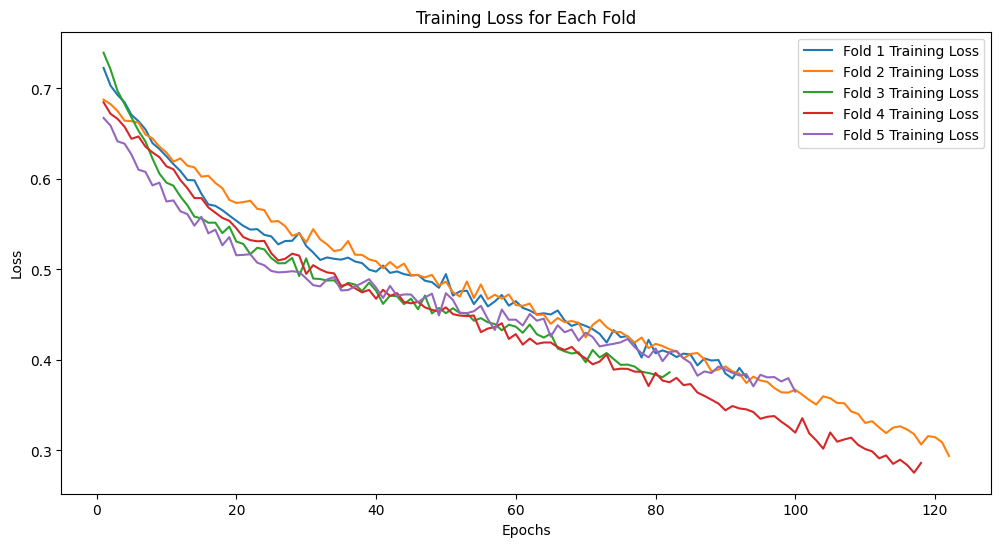

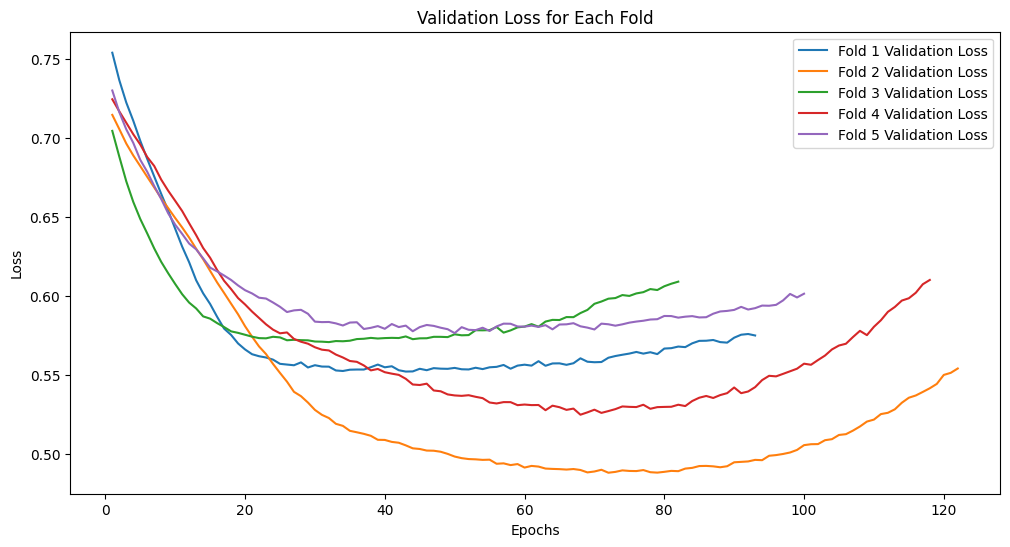

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 6))
for i, train_loss in enumerate(train_loss_list):
    plt.plot(
        range(1, len(train_loss) + 1), train_loss, label=f"Fold {i+1} Training Loss"
    )
plt.title("Training Loss for Each Fold")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot the validation loss for each fold
plt.figure(figsize=(12, 6))
for i, val_loss in enumerate(val_loss_list):
    plt.plot(range(1, len(val_loss) + 1), val_loss, label=f"Fold {i+1} Validation Loss")
plt.title("Validation Loss for Each Fold")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()